# **Fitting correlated backgrounds with flarefly**

The goal of this tutorial is to provide an example of how to handle correlated backgrounds in invariant mass fits using the package [flarefly](https://flarefly.github.io/flarefly/index.html).

This tutorial will provide an example on how to fit correlated backgrounds using flarefly, using a toy dataset. Typically, in high-energy physics, the correlated backgrounds can arise from partially reconstructed decays or misidentified particles. Their shape is usually described from Monte Carlo simulations, while their normalisation can be fixed to the signal using branching ratio informations and efficiencies. In this tutorial, we will discuss how to implement such a fit using flarefly.

## **Prerequisites**

To run the following code, you need to have [flarefly](https://flarefly.github.io/flarefly/index.html) installed. You can install it via pip:

In [1]:
%%capture
!pip install flarefly

## **Required python packages**

The packages required for the tutorial are imported in the following.

In [2]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from flarefly import DataHandler, F2MassFitter

## **Prepare data | DataHandler instance**

The data used in this tutorial will be a toy dataset created using numpy. We will create a dataset with a Gaussian signal, an exponential background and a correlated background modeled with another Gaussian distribution, with a large width.

In [3]:
N_SGN = 10000
N_BKG = 50000
REL_FRACTION_CORR_BKG = 0.5
N_CORR_BKG = int(N_SGN * REL_FRACTION_CORR_BKG)
N_CORR_BKG_FOR_TEMPLATE = 10000
DATA_SGN = np.random.normal(loc=1., scale=0.05, size=N_SGN)
DATA_BKG = np.random.exponential(scale=1, size=N_BKG)
DATA_CORR_BKG = np.random.normal(loc=2., scale=0.4, size=N_CORR_BKG)
DATA_CORR_BKG_FOR_TEMPLATE = np.random.normal(loc=2., scale=0.4, size=N_CORR_BKG_FOR_TEMPLATE)
DATA = np.concatenate([DATA_SGN, DATA_BKG, DATA_CORR_BKG])

We can draw the data using matplotlib:

Text(0, 0.5, 'Counts')

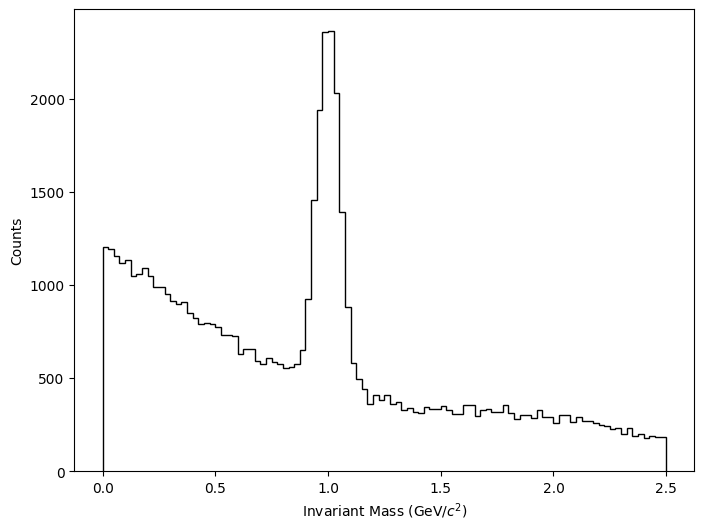

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(DATA, bins=100, range=(0, 2.5), histtype='step', color='black')
ax.set_xlabel(r'Invariant Mass (GeV/$c^2$)')
ax.set_ylabel('Counts')

*flarefly* allows for a simple handling of the data by calling a *DataHandler* instance that shall take care of adapting the input to our fitter class.

**NB**: In this case the input data are _unbinned_.

In [5]:
data = DataHandler(data=DATA,
                   var_name=r"$M$ (GeV/$c^{2}$)",
                   limits=[0, 2.5]
                   )

## **Prepare fitter | F2MassFitter instance**

Once data are prepared, one still needs to configure the fitter:

1. Define probability density functions (PDFs) for signal and background
2. Define a F2MassFitter instance
3. Initialize fit parameters

### **1. Define PDFs**

flarefly is built on top of zfit, which is optimized for direct manipulation of probability density functions (PDFs). This makes it necessary to define PDFs separately for the signal and the background.

**NB**: While flarefly supports extended likelihood fits, its default behavior is to perform non-extended likelihood fits. In this case:

- The total PDF is normalized to the number of entries in the dataset.
- The yields of the different components are expressed as fractions of the total number of entries.

Since the fractions must sum to 1, the following constraint applies:
$$
\sum_i f_i = 1
$$
where $f_i$ is the fraction of the i-th component. In flarefly, each PDF is associated with a fraction parameter (named _frac_), except for the last component. The fraction of the last component (either the last background PDF, if any, or otherwise the last signal PDF) is automatically computed as $1 - \sum_{i \neq j} f_i$. 

Therefore, if you want to fix the fraction of a correlated background with respect to the signal, make sure that the correlated background PDF is not the last component, so that its fraction can be explicitly set.

In this tutorial, we will use a Kernel Density Estimation (KDE) grid to model the correlated background shape.

In [6]:
# define PDFs lists
signal_pdfs = ["gaussian"]
background_pdfs = ["kde_grid", "expo"]  # correlated bkg + exp bkg
labels_bkg = ["Correlated Bkg", "Combinatorial Bkg"]

# define the ids
gaussian_id = 0 # because signal_pdfs[gaussian_id] = "gaussian"
kde_id = 0      # because background_pdfs[kde_id] = "kde_grid"
expo_id = 1     # because background_pdfs[expo_id] = "expo"

### **2. Define a F2MassFitter instance**



In [7]:
fitter = F2MassFitter(data_handler=data,
                      name_signal_pdf=signal_pdfs,
                      name_background_pdf=background_pdfs,
                      label_bkg_pdf=labels_bkg,
                      name=f"{background_pdfs[kde_id]}_{background_pdfs[expo_id]}_{signal_pdfs[gaussian_id]}")

### **3. Initialize fit parameters**

We can now initialize the fit parameters.

In [8]:
fitter.set_signal_initpar(gaussian_id, "mu", 1.0)
fitter.set_signal_initpar(gaussian_id, "frac", 0.15)
fitter.set_signal_initpar(gaussian_id, "sigma", 0.05)

fitter.set_background_initpar(expo_id, "lam", -1.)

Here the magic happens: we can fix the fraction of the correlated background with respect to the signal using the method `fix_bkg_frac_to_signal_pdf`, which takes care of linking the fraction parameter of the correlated background to the signal yield. It requires as input the id of the background PDF, that of the signal PDF to which the correlated background fraction must be linked, and the relative fraction value. Different flavours of this method are available:
- `fix_bkg_frac_to_signal_pdf`
- `fix_signal_frac_to_signal_pdf`
- `fix_bkg_frac_to_bkg_pdf`
- `fix_signal_frac_to_bkg_pdf`

In [9]:
fitter.fix_bkg_frac_to_signal_pdf(kde_id, gaussian_id, REL_FRACTION_CORR_BKG)

Lastly, we need to set the shape of the correlated background PDF. In this case, we will use a Kernel Density Estimation (KDE) grid. Again, to pass the data to the fitter, we can use the `DataHandler` class.

Pay attention that the data used to build the KDE must have the same limits as the main data used for the fit, or zfit will raise an error.

In [10]:
data_hdl_kde = DataHandler(data=DATA_CORR_BKG_FOR_TEMPLATE,
                           var_name=r"$M$ (GeV/$c^{2}$)",
                           limits=[0, 2.5]
                           )
fitter.set_background_kde(kde_id, data_hdl_kde)

## **The actual (one-liner) mass fit**

The method _mass_zfit_ builds a total PDF (from the signal and background ones) to fit data using _zfit_ library.

In [11]:
fitter.mass_zfit()

INFO: Performing FIT
I MnSeedGenerator Computing seed using NumericalGradient calculator
I MnSeedGenerator Initial state: FCN =             10000 Edm =       38.73225834 NCalls =     11
I MnSeedGenerator Initial state  
  Minimum value : 10000
  Edm           : 38.73225834
  Internal parameters:	[    -0.7753974966      1.732050808     0.3201562119               -1]	
  Internal gradient  :	[      -1743.95568      -2320.48679      1213.369917     -118.3043817]	
  Internal covariance matrix:
[[  4.3961568e-05              0              0              0]
 [              0  1.3608706e-06              0              0]
 [              0              0  8.0869716e-06              0]
 [              0              0              0  0.00014226543]]]
I VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 680
I VariableMetricBuilder    0 - FCN =             10000 Edm =       38.73225834 NCalls =     11
I VariableMetricBuilder    1 - FCN =        9969.83552 Edm =       5.1

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_2, kde_grid_expo_gaussian_frac_bkg0_constrained_to_signal0, kde_grid_expo_gaussian_frac_signal0]] data=[<zfit.Data: Data obs=('$M$ (GeV/$c^{2}$)',) shape=(60434, 1)>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 1.5e-07 │         41756.31 |  9960.114 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name                                    value  (rounded)        hesse    at limit
------------------------------------  ------------------  -----------  ----------
kde_grid_expo_gaussian_frac_signal0             0.167129  +/-  0.0021    

**NB**: one can directly store the fit result in a variable via *fitres = fitter.mass_zfit()* or call it later on as follows: *fitres = fitter.get_fit_result()*.

## **Draw plots**

*flarefly* provides plot utils to draw:
- the invariant mass fit of the total PDF, along with the signal PDF and background PDF. There is the possibility to plot _extra_info_ such as parameters, signal and background derived quantities;
- the raw residuals of the fit: (data_value - bkg_model_value);
- the standardized residuals of the fit: (data_value - bkg_model_value)/ sigma_data .

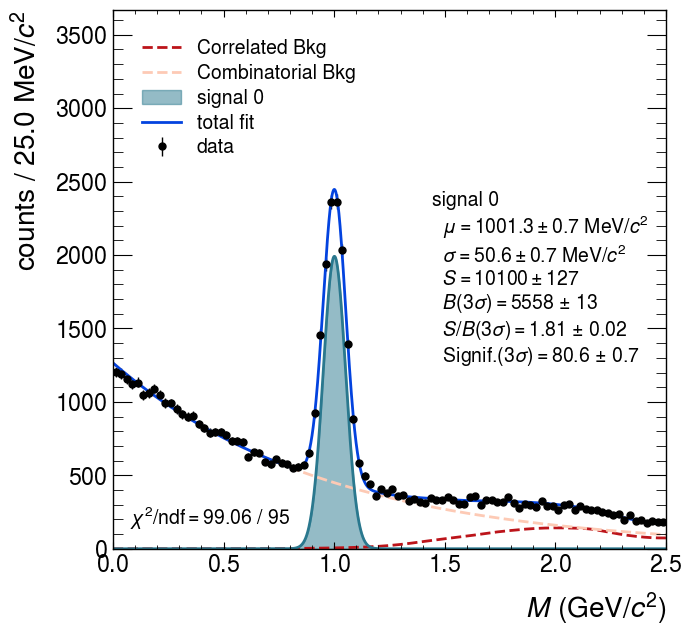

In [12]:
# plot the fit result with display options
plot_mass_fit = fitter.plot_mass_fit(style="ATLAS",
                    show_extra_info=True,
                    extra_info_loc=['lower left', 'center right'],
                    legend_loc='upper left')

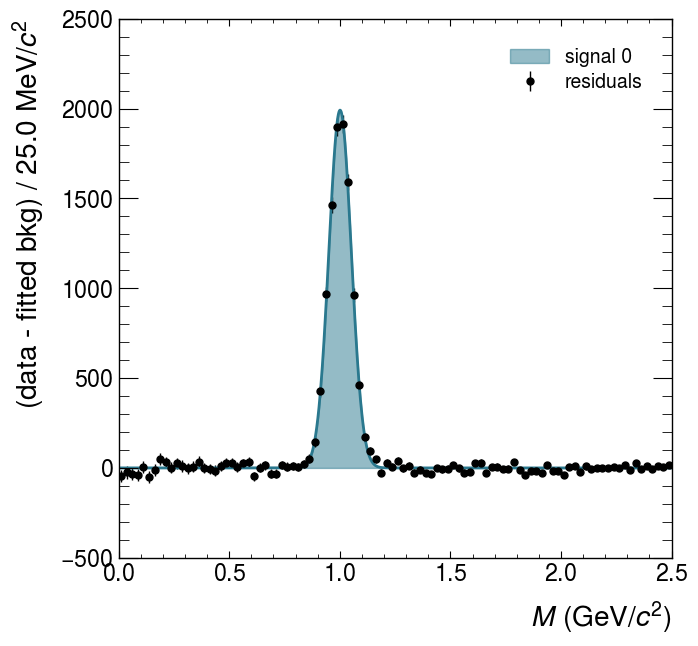

In [13]:
plot_raw_residuals = fitter.plot_raw_residuals(style="ATLAS")

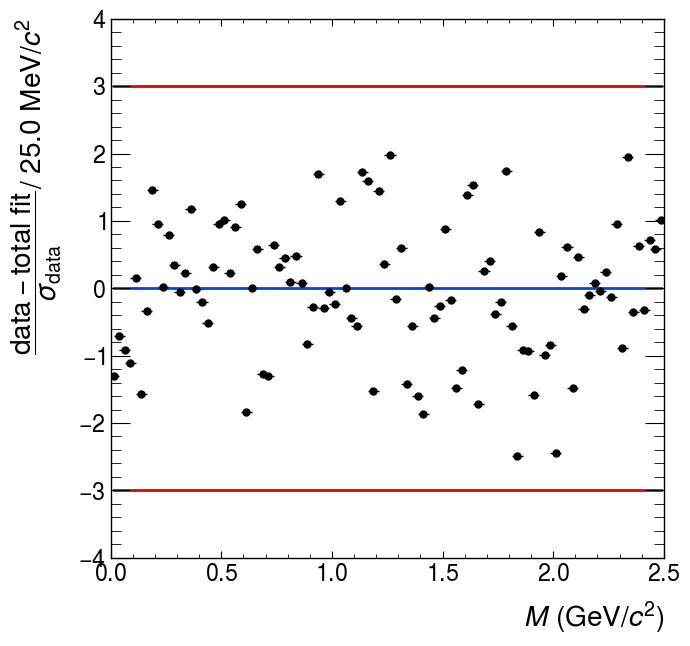

In [14]:
plot_std_residuals = fitter.plot_std_residuals(style="ATLAS")